In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
ins_data = pd.read_pickle('../../data/feature engineered/insurance.pkl')
ins_data

,age,sex,bmi,children,smoker,region,charges
0,-0.854167,-1.0,-0.304319,-0.5,-0.590433,0.000000,0.475094
1,-1.020833,0.0,0.389592,0.0,0.000000,1.000000,-1.302772
2,-0.447917,0.0,0.302496,1.0,0.000000,1.000000,-0.585858
3,-0.239583,0.0,-0.987437,-0.5,0.000000,0.000000,0.692467
4,-0.281250,0.0,-0.183343,-0.5,0.000000,0.000000,-0.693955
...,...,...,...,...,...,...,...
1333,0.468750,0.0,0.067477,1.0,0.000000,0.000000,0.097725
1334,-1.020833,-1.0,0.178465,-0.5,0.000000,-0.025641,-1.119708
1335,-1.020833,-1.0,0.727647,-0.5,0.000000,1.000000,-1.345025
1336,-0.739583,-1.0,-0.571484,-0.5,0.000000,0.000000,-1.190043


In [3]:
Y = ins_data.loc[:, 'charges']
X = ins_data.drop('charges', axis=1)

In [4]:
X.shape, Y.shape

((1338, 6), (1338,))

In [5]:
freg_selection = SelectKBest(score_func=f_regression, k=4)
freg_selection.fit(X, Y)
df = freg_selection.transform(X)
df = pd.DataFrame(df, columns=['age', 'bmi', 'children', 'smoker'])
df

,age,bmi,children,smoker
0,-0.854167,-0.304319,-0.5,-0.590433
1,-1.020833,0.389592,0.0,0.000000
2,-0.447917,0.302496,1.0,0.000000
3,-0.239583,-0.987437,-0.5,0.000000
4,-0.281250,-0.183343,-0.5,0.000000
...,...,...,...,...
1333,0.468750,0.067477,1.0,0.000000
1334,-1.020833,0.178465,-0.5,0.000000
1335,-1.020833,0.727647,-0.5,0.000000
1336,-0.739583,-0.571484,-0.5,0.000000


## modeling

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

***polynomial regression***

In [9]:
# transform data into polynomial
poly = PolynomialFeatures(degree=2)
df_poly_2 = poly.fit_transform(df)

In [13]:
ols_poly = LinearRegression()
ridge_poly = Ridge(alpha=0.1)

In [15]:
cv_poly = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)

scores_ols = cross_val_score(ols_poly, df, Y, cv=cv_poly, scoring='r2')
scores_ols_poly = cross_val_score(ols_poly, df_poly_2, Y, cv=cv_poly, scoring='r2')
scores_ridge = cross_val_score(ridge_poly, df, Y, cv=cv_poly, scoring='r2')
scores_ridge_poly = cross_val_score(ridge_poly, df_poly_2, Y, cv=cv_poly, scoring='r2')

In [18]:
print(f'ols\n'
      f'average score: {np.mean(scores_ols) * 100}\n'
      f'standard deviation: {np.std(scores_ols)}')
print('')
print(f'ols poly\n'
      f'average score: {np.mean(scores_ols_poly) * 100}\n'
      f'standard deviation: {np.std(scores_ols_poly)}')
print('')
print(f'ridge\n'
      f'average score: {np.mean(scores_ridge) * 100}\n'
      f'standard deviation: {np.std(scores_ridge)}')
print('')
print(f'ridge poly\n'
      f'average score: {np.mean(scores_ridge_poly) * 100}\n'
      f'standard deviation: {np.std(scores_ridge_poly)}')

ols
average score: 76.53664271218375
standard deviation: 0.02557367684062083

ols poly
average score: 82.68311537483257
standard deviation: 0.02584735797457758

ridge
average score: 76.5370667153086
standard deviation: 0.025506702152917508

ridge poly
average score: 82.68535006114197
standard deviation: 0.025847224796844273


****Tune alpha for 2 degree polynomial ridge****

In [20]:
ridge_tuning_model = Ridge()

grid = dict()
grid['alpha'] = np.arange(0, 1, 0.001)

# searching grid
grid_search = GridSearchCV(ridge_tuning_model, grid, scoring='r2', cv=cv_poly)
result = grid_search.fit(df_poly_2, Y)

In [21]:
result.best_params_, result.best_score_, result.best_estimator_

({'alpha': 0.395}, 0.8268800164700203, Ridge(alpha=0.395))

***higher degree polynomial***

In [22]:
df_poly_3 = PolynomialFeatures(degree=3).fit_transform(df)
df_poly_4 = PolynomialFeatures(degree=4).fit_transform(df)
df_poly_5 = PolynomialFeatures(degree=5).fit_transform(df)

In [25]:
# fits higher order polys
result_poly_3 = GridSearchCV(ridge_tuning_model,
                             grid, cv=cv_poly, scoring='r2').fit(df_poly_3, Y)
result_poly_4 = GridSearchCV(ridge_tuning_model,
                             grid, cv=cv_poly, scoring='r2').fit(df_poly_4, Y)
result_poly_5 = GridSearchCV(ridge_tuning_model,
                             grid, cv=cv_poly, scoring='r2').fit(df_poly_5, Y)

In [26]:
print(f'poly 3\n'
      f'best score: {result_poly_3.best_score_ * 100}\n'
      f'best parameter: {result_poly_3.best_params_}')
print('')
print(f'poly 4\n'
      f'best score: {result_poly_4.best_score_ * 100}\n'
      f'best parameter: {result_poly_4.best_params_}')
print('')
print(f'poly 4\n'
      f'best score: {result_poly_5.best_score_ * 100}\n'
      f'best parameter: {result_poly_5.best_params_}')

poly 3
best score: 82.75324277912995
best parameter: {'alpha': 0.41400000000000003}

poly 4
best score: 82.37996876066684
best parameter: {'alpha': 0.999}

poly 4
best score: 81.98771270934316
best parameter: {'alpha': 0.999}


In [30]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, train_size=0.8, random_state=64)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1070, 4), (268, 4), (1070,), (268,))

In [33]:
ridge_poly_2_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                               ('ridge', Ridge(alpha=0.395))])
ridge_poly_3_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                               ('ridge', Ridge(alpha=0.414))])
ridge_poly_4_model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                               ('ridge', Ridge(alpha=0.999))])
ridge_poly_5_model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                               ('ridge', Ridge(alpha=0.999))])

ridge_poly_2_model = ridge_poly_2_model.fit(x_train, y_train)
ridge_poly_3_model = ridge_poly_3_model.fit(x_train, y_train)
ridge_poly_4_model = ridge_poly_4_model.fit(x_train, y_train)
ridge_poly_5_model = ridge_poly_5_model.fit(x_train, y_train)

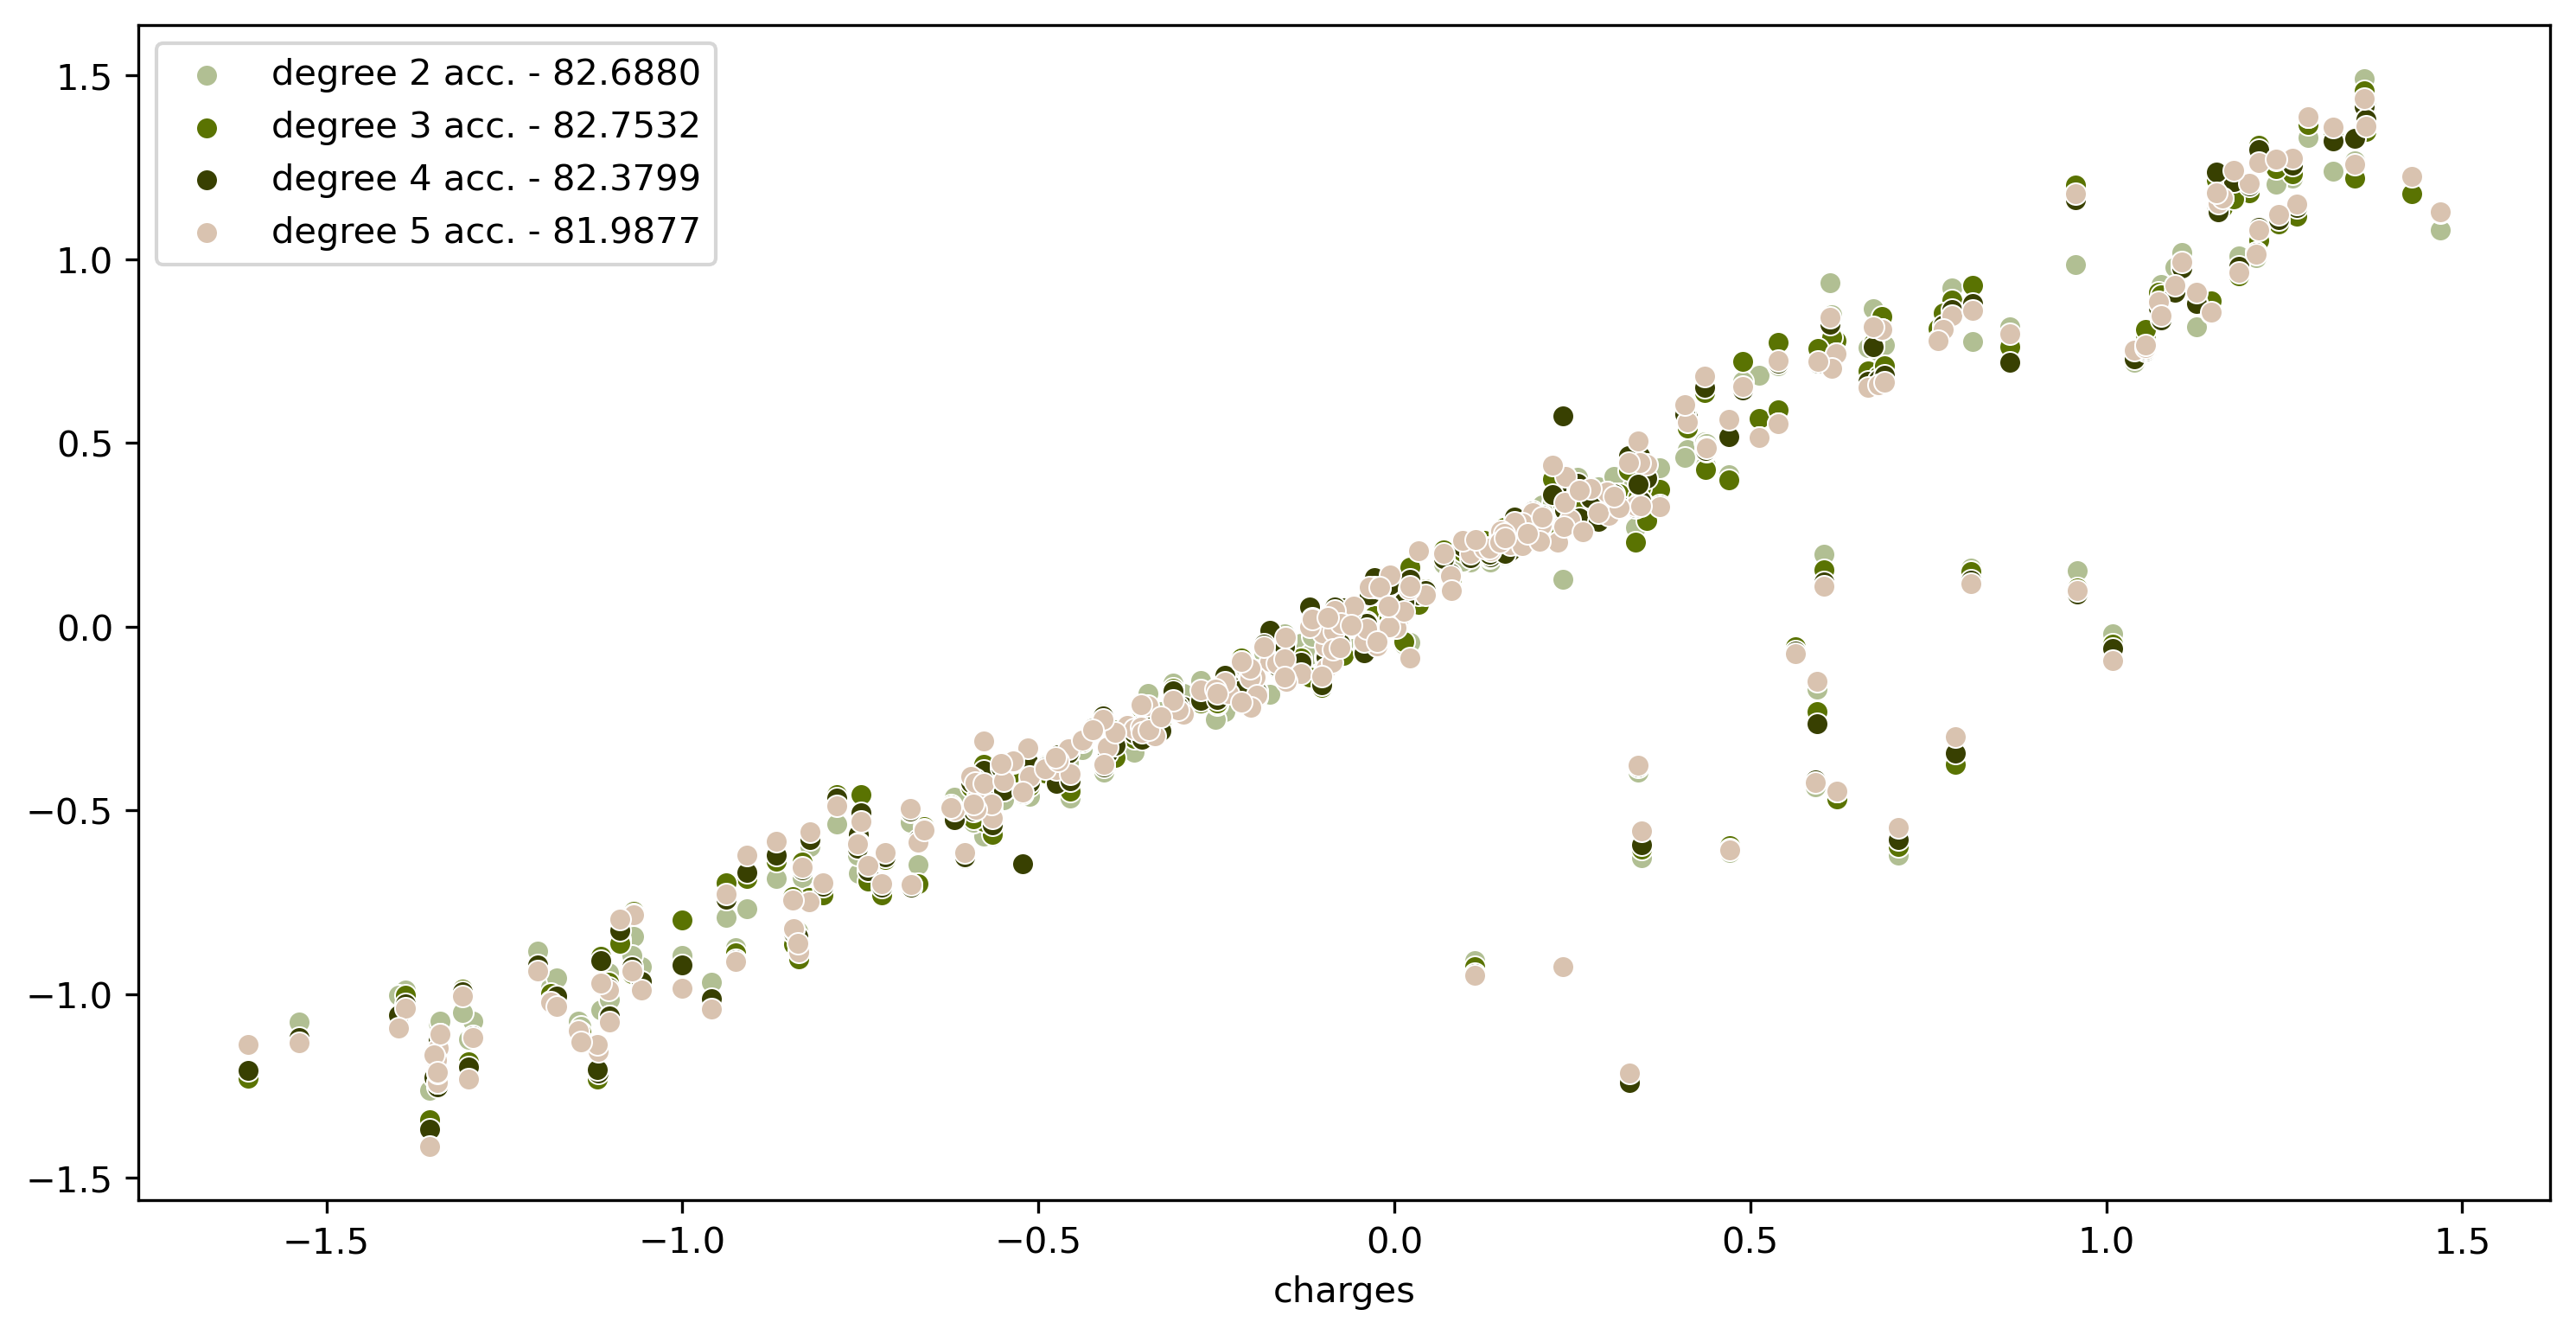

In [36]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=y_test, y=ridge_poly_2_model.predict(x_test),
                color='#B1BF93', label='degree 2 acc. - 82.6880')
sns.scatterplot(x=y_test, y=ridge_poly_3_model.predict(x_test),
                color='#5A7302', label='degree 3 acc. - 82.7532')
sns.scatterplot(x=y_test, y=ridge_poly_4_model.predict(x_test),
                color='#384001', label='degree 4 acc. - 82.3799')
sns.scatterplot(x=y_test, y=ridge_poly_5_model.predict(x_test),
                color='#D9C3B0', label='degree 5 acc. - 81.9877')
plt.legend()
plt.savefig('../../demo/Model Creation/compare degree of polynomial function.png')
plt.show()

****KNN models****

In [41]:
cv = RepeatedKFold(n_splits=6, n_repeats=12, random_state=1)

knn_scores = dict()
grid_knn = dict()
grid_knn['n_neighbors'] = list(range(3, 20, 2))

weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute']

for w in weights:
    for a in algorithm:
        knn_tuning_model = KNeighborsRegressor(weights=w, algorithm=a)
        knn_scores[f'{w}_{a}'] = GridSearchCV(knn_tuning_model, grid_knn,
                                              cv=cv, scoring='r2').fit(df, Y)

In [44]:
for k in knn_scores.keys():
    print(f'{k}\n'
          f'{knn_scores[k].best_score_}\n'
          f'{knn_scores[k].best_estimator_}')
    print('')

uniform_ball_tree
0.7884833836102637
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=9)

uniform_kd_tree
0.7885172036874932
KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9)

uniform_brute
0.7885023498601195
KNeighborsRegressor(algorithm='brute', n_neighbors=9)

distance_ball_tree
0.7704419403986571
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, weights='distance')

distance_kd_tree
0.7704524305423561
KNeighborsRegressor(algorithm='kd_tree', n_neighbors=11, weights='distance')

distance_brute
0.7704481248546898
KNeighborsRegressor(algorithm='brute', n_neighbors=11, weights='distance')



In [45]:
knn_model_2 = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9).fit(x_train, y_train)
knn_model_5 = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=11, weights='distance').fit(x_train, y_train)

knn_model_2_pred = knn_model_2.predict(x_test)
knn_model_5_pred = knn_model_5.predict(x_test)

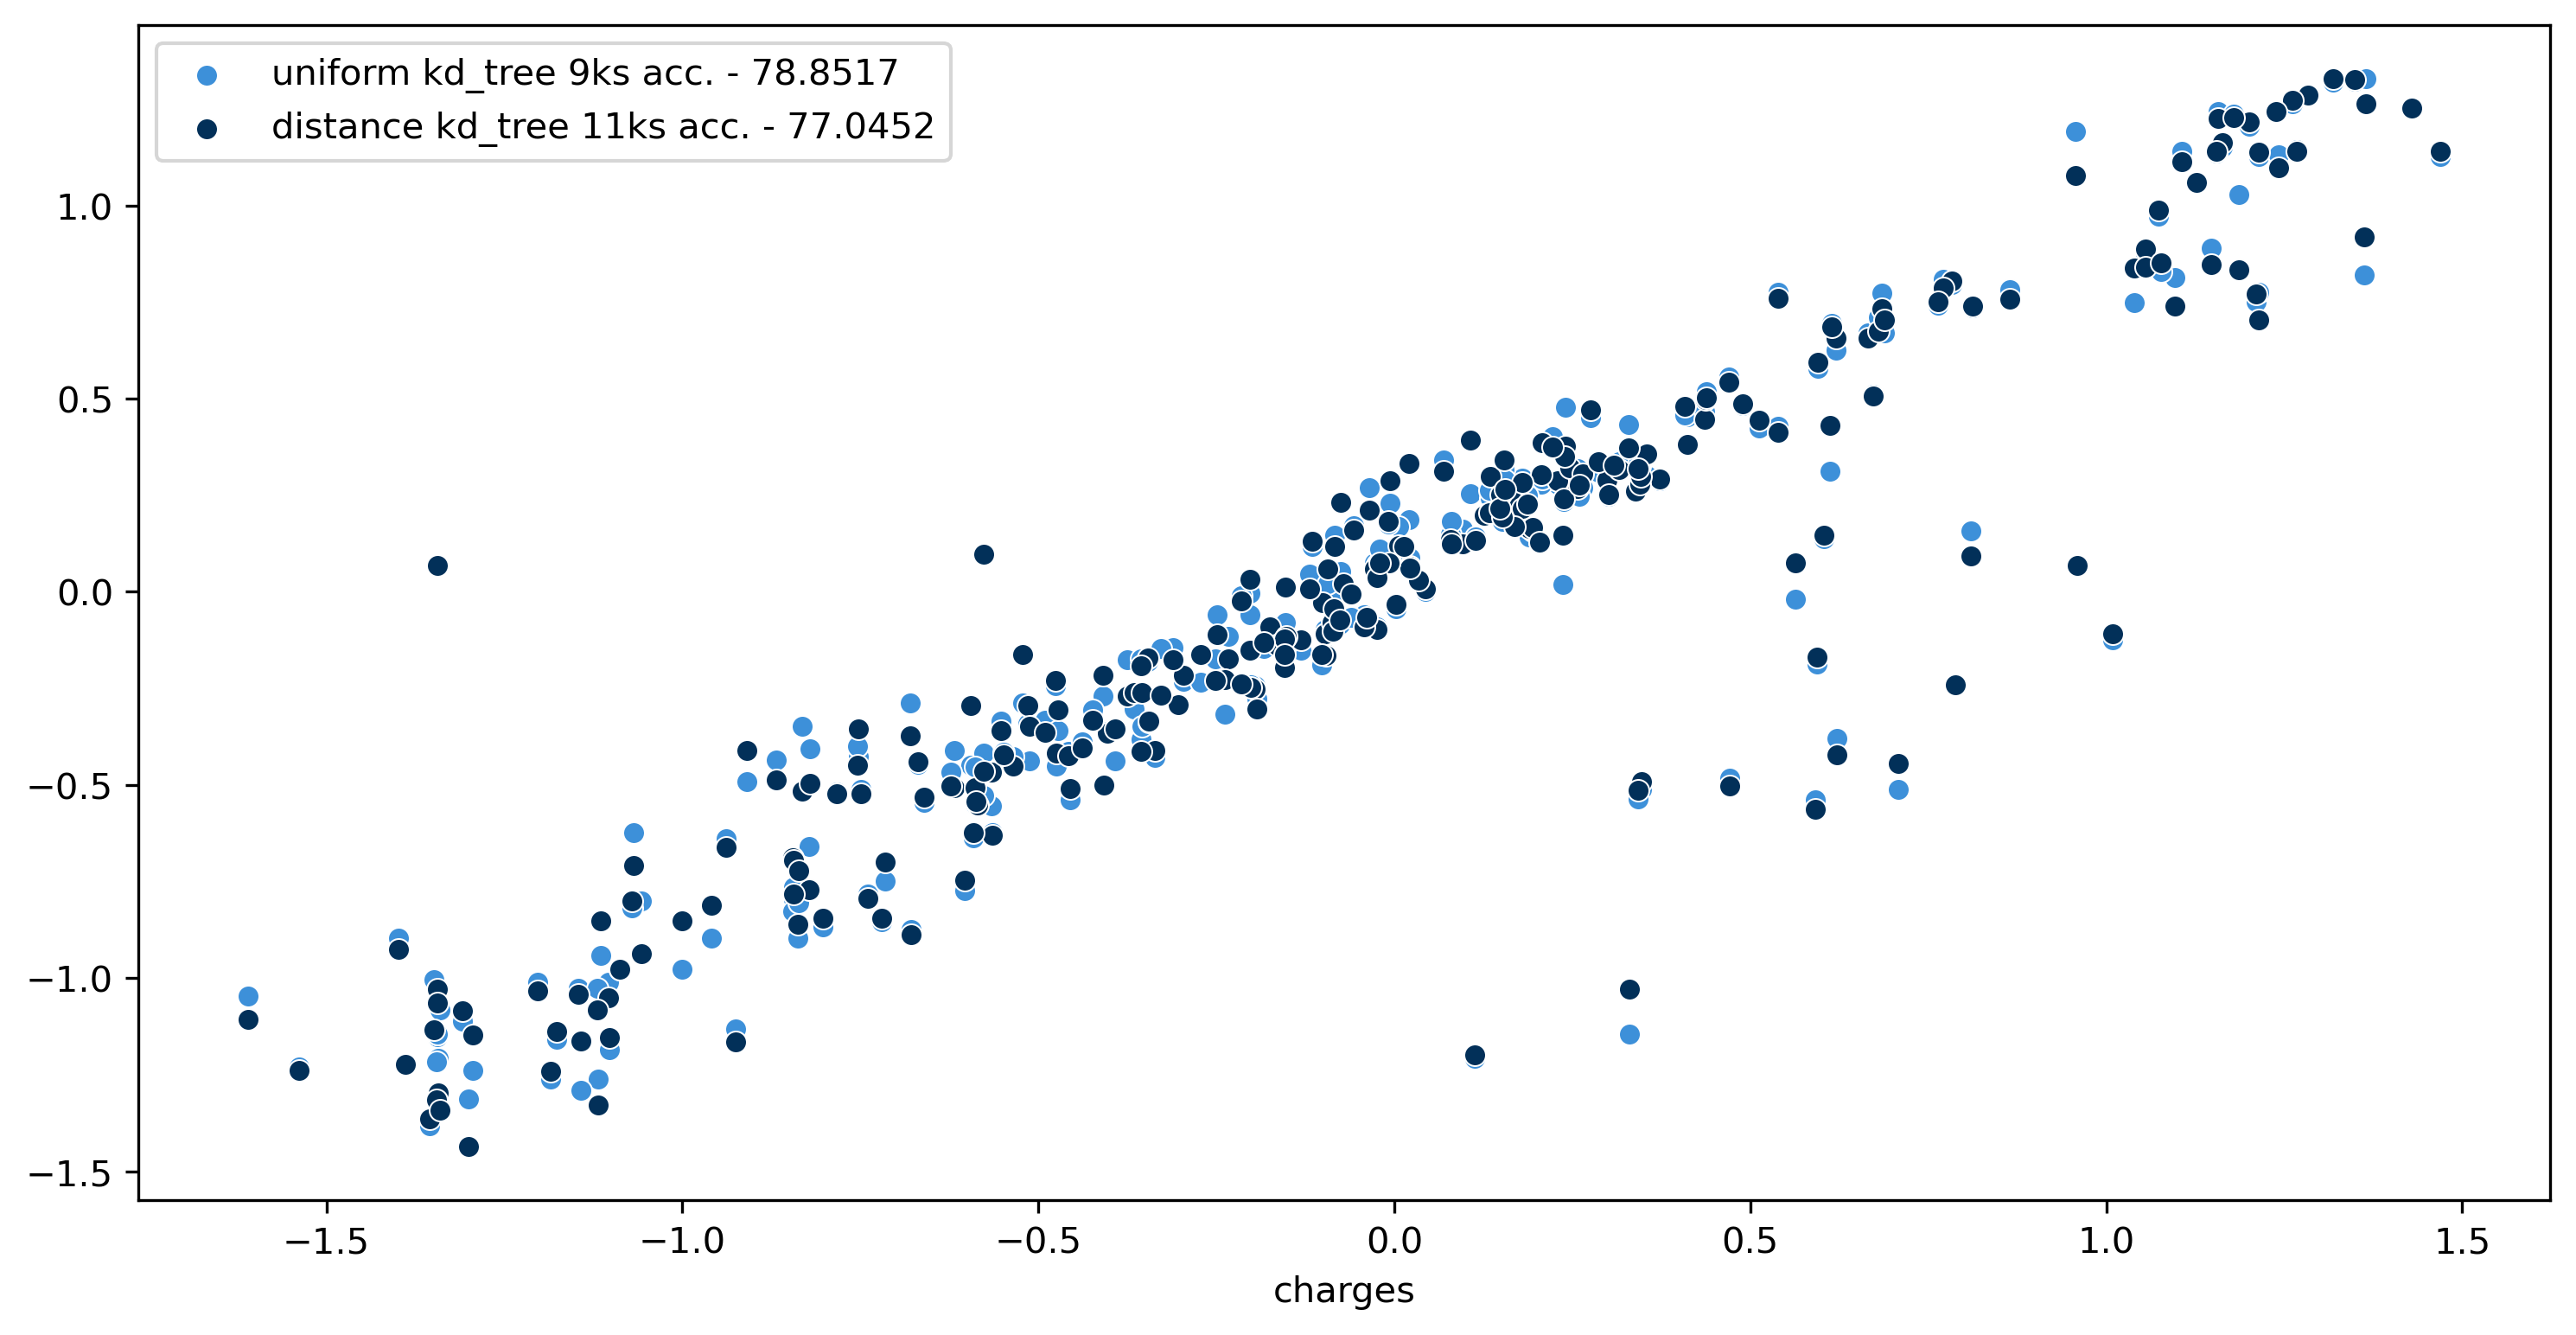

In [48]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=y_test, y=knn_model_2_pred,
                color='#3D90D9',
                label='uniform kd_tree 9ks acc. - 78.8517')
sns.scatterplot(x=y_test, y=knn_model_5_pred,
                color='#023059',
                label='distance kd_tree 11ks acc. - 77.0452')
plt.legend()
plt.savefig('../../demo/Model Creation/compare knn models.png')
plt.show()
